# Vertical 2-Dimensional Example

Here we simulate phytoplankton cells as Lagrangian particles in a 2D flow field.
The domain is periodic in x direction but bounded in z direction

## 1. Import packages

In [1]:
using PlanktonIndividuals, Plots

## 2. Generate Flow Fields

First we'll generate grid information

In [2]:
grid = gen_Grid(size=(128, 1, 128), spacing=(1, 1, 1))

domain: x ∈ [0.0, 128.0], y ∈ [0.0, 1.0], z ∈ [-128.0, 0.0]
resolution (Nx, Ny, Nz):   (128, 1, 128)
halo size (Hx, Hy, Hz):    (2, 2, 2)
grid spacing (Δx, Δy, Δz): (1, 1, 1)

Then we use a stream function to generate the flow fields

In [3]:
scal = 2e-1
f(x, y, z) = scal*sin(x*2π/128)*sin(z*2π/128) #stream function

ϕcorners=[f(x,0.,z) for x in 0:128, z in -128:0]
ϕcenters=[f(x,0.,z) for x in 0.5:128, z in -128:-0.5]

uu=-diff(ϕcorners,dims=2)[1:end-1,:]
ww=diff(ϕcorners,dims=1)
uu=reshape(uu,(128,1,128))
ww=reshape(ww,(128,1,129))

uvels = fill(uu, 2)
vvels = fill(0*uu, 2)
wvels = fill(ww, 2)
uvels = cat(uvels..., dims=4)
vvels = cat(vvels..., dims=4)
wvels = cat(wvels..., dims=4)

nothing

## 3. Model Setup

Next we setup the individual-based model by specifying the architecture, grid,
number of individuals, parameters, and nutrient initial conditions.

In [4]:
model = PI_Model(CPUs(), grid; individual_size = (Nsp = 1, N = 2^7, cap = 8),
                 nut_source = [1.0, 0.02, 0.05, 0.01, 1.0, 0.1, 0.02, 0.2, 0.02, 0.001])

grid: Nx = 128, Ny = 1, Nz = 128
individuals: 1 phytoplankton species each with 128 individuals
capacity of individuals: 1024 per species
diagnostics of tracers: (:PAR, :DOC, :NH4, :NO3)
diagnostics of individuals: (:num, :graz, :mort, :dvid)

We also need to setup a runtime simulation to run the model.
The simulation includes time step, number of time steps, flow fields that
will be used etc.

In [5]:
sim = PI_simulation(model, ΔT = 60, nΔT = 1, diag_freq = 3600,
                    vels=(u=uvels, v=vvels, w=wvels),
                    vel_reuse = true)

ΔT: 60s
model time: 0s
number of time steps: 1
save averaged diagnostics every 3600s, 60 time steps
results saved at nothing
save diags: false
save individuals: false
reuse velocity fields: true


## 4. Run the Model

Finaly, we run the model and plot the distribution of individuals as well as nutrient fields
We use Plots.jl to plot individuals and nutrient fields.

In [6]:
function plot(model::PI_Model)
    # Coordinate arrays for plotting
    xC, zC = collect(model.grid.xC)[3:130], collect(model.grid.zC)[3:130]

    # heatmap of the flow field
    fl_plot = Plots.contourf(xC, zC, ϕcenters', xlabel="x (m)", ylabel="z (m)", color=:balance, fmt=:png, colorbar=false)

    # a scatter plot embeded in the flow fields
    px = Array(model.individuals.phytos.sp1.data.x)
    pz = Array(model.individuals.phytos.sp1.data.z)
    Plots.scatter!(fl_plot, px, pz, ms=5, color = :red, legend=:none)

    # DOC field
    trac1 = Plots.contourf(xC, zC, Array(model.nutrients.DOC.data)[3:130,3,3:130]', xlabel="x (m)", ylabel="z (m)", clims=(0.5, 1.1), fmt=:png)

    # Arrange the plots side-by-side.
    plt = Plots.plot(fl_plot, trac1, size=(800, 400),
        title=[lpad(model.t÷86400,2,"0")*"day "*lpad(model.t÷3600-24*(model.t÷86400),2,"0")*"hour" "DOC (mmolC/L)"])

    return plt
end

plot (generic function with 1 method)

We run the model for 120 time steps (2 hour) and plot the individuals and DOC field.

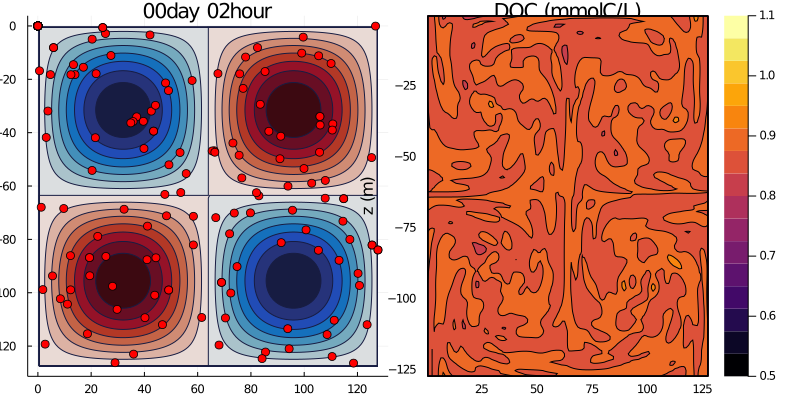

In [7]:
for i in 1:120
    update!(sim)
end

plot(model)

Or you can use the following code to generate an animation like below

```
anim = @animate for i in 1:120
   update!(sim)
   plot(model)
end
gif(anim, "anim_fps15.gif", fps = 15)
```
![animation](https://github.com/JuliaOcean/PlanktonIndividuals.jl/raw/master/examples/figures/anim_vertical_2D.gif)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*